In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.api as sm

In [3]:
last=pd.read_csv("data/data_last.csv")
mkt_cap=pd.read_csv('data/data_mkt_cap.csv')
sector=pd.read_csv('data/data_sector.csv')
volume=pd.read_csv('data/data_volume.csv')

In [4]:
last[last['ticker']!=mkt_cap['ticker']]

,ticker,date,last


In [5]:
last[last['date']!=mkt_cap['date']]

,ticker,date,last


In [6]:
last[last['ticker']!=volume['ticker']]

,ticker,date,last


In [7]:
last[last['date']!=volume['date']]

,ticker,date,last


In [8]:
data=last
data['volume']=volume['volume']
data['mkt_cap']=mkt_cap['mkt_cap']
data=pd.merge(data,sector,on='ticker')

In [9]:
data['price']=data.groupby('ticker')['last'].shift(-1)
data['ret']=(data['price']-data['last'])/data['last']
data['amount']=data['price']*data['volume']
data['factor1']=data.groupby('ticker')['amount'].apply(lambda x: (x/x.rolling(window=10).mean()).shift(1))
data['factor2']=data.groupby('ticker')['ret'].apply(lambda x:x.shift(1))
data['date']=pd.to_datetime(data['date'])
factor3=-data.groupby('ticker')[['price','volume']].rolling(10).corr().iloc[::2,1]
factor3.index=factor3.index.get_level_values(1)
data['factor3']=factor3.shift(1)
data['pri_chg']=data['price']/data['last']
data['factor4']=data.groupby('ticker')['volume'].apply(lambda x: (x.diff().shift(-1)/x).shift(2))
data['factor5']=data.groupby('ticker')['volume'].apply(lambda x: np.sign(x.shift(1)-x.shift(2)))
data['factor5']=-data['factor5']*(data['price']-data['last']).shift(1)

In [10]:
data

,ticker,date,last,volume,mkt_cap,bics_sector,price,ret,amount,factor1,factor2,factor3,pri_chg,factor4,factor5
0,1332 JT,2017-08-16,562.12,1641300.0,199642.95,"Consumer, Non-cyclical",560.36,-0.003131,9.197189e+08,NaN,NaN,NaN,0.996869,NaN,NaN
1,1332 JT,2017-08-17,560.36,1247700.0,199018.09,"Consumer, Non-cyclical",553.32,-0.012563,6.903774e+08,NaN,-0.003131,NaN,0.987437,NaN,NaN
2,1332 JT,2017-08-18,553.32,1505800.0,196518.64,"Consumer, Non-cyclical",544.53,-0.015886,8.199533e+08,NaN,-0.012563,NaN,0.984114,-0.239810,-7.04
3,1332 JT,2017-08-21,544.53,2046200.0,193394.34,"Consumer, Non-cyclical",535.73,-0.016161,1.096211e+09,NaN,-0.015886,NaN,0.983839,0.206861,8.79
4,1332 JT,2017-08-22,535.73,2409300.0,190270.04,"Consumer, Non-cyclical",544.53,0.016426,1.311936e+09,NaN,-0.016161,NaN,1.016426,0.358879,8.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420532,9984 JT,2024-02-29,8790.00,10544100.0,12921258.07,Communications,8907.00,0.013311,9.391630e+10,0.623399,-0.014574,0.314904,1.013311,-0.364177,-130.00
420533,9984 JT,2024-03-01,8907.00,12555200.0,13093247.51,Communications,8934.00,0.003031,1.121682e+11,0.757210,0.013311,0.333093,1.003031,0.129451,-117.00
420534,9984 JT,2024-03-04,8934.00,12317400.0,13132937.38,Communications,9008.00,0.008283,1.109551e+11,0.925269,0.003031,0.250435,1.008283,0.190732,-27.00
420535,9984 JT,2024-03-05,9008.00,10072900.0,13241717.03,Communications,8874.00,-0.014876,8.938691e+10,0.935869,0.008283,0.210609,0.985124,-0.018940,74.00


In [11]:
dt=data.groupby('ticker').fillna(method='ffill')
dt=dt.dropna()
dt['ticker']=data.iloc[dt.index,0]
train=dt[dt['date']<datetime(2022,8,16)]
test=dt[dt['date']>=datetime(2022,8,16)]

In [12]:
def neutralization(factor,mkt_cap,sector):
    dummy_sec=pd.get_dummies(sector)
    X=pd.concat([np.log(mkt_cap),dummy_sec],axis=1)
    y=factor
    y[np.isinf(y)]=0
    X=sm.add_constant(X)
    model=sm.OLS(y,X).fit()
    return model.resid

# Train

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\3139483636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['neu_fac1']=neu_fac1


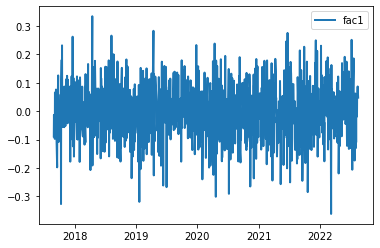

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\3139483636.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group1']=train.groupby('date')['neu_fac1'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\3139483636.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last_group1']=train.groupby('ticker')['group1'].shift(1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\3139483636.py:15: SettingWithCopyWarning: 
A value is trying to be set on a

group
0.0    AxesSubplot(0.125,0.2;0.775x0.68)
1.0    AxesSubplot(0.125,0.2;0.775x0.68)
2.0    AxesSubplot(0.125,0.2;0.775x0.68)
3.0    AxesSubplot(0.125,0.2;0.775x0.68)
4.0    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumret, dtype: object

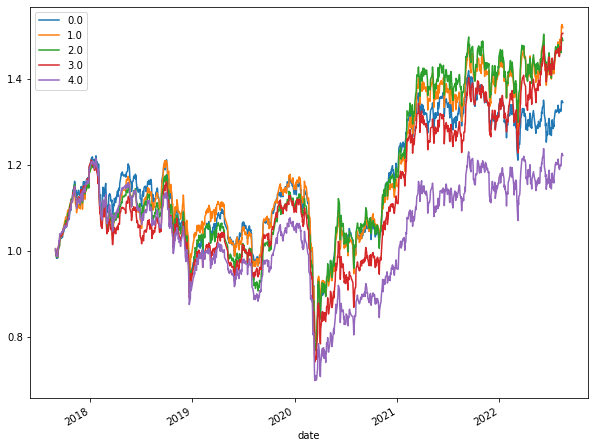

In [13]:
neu_fac1=train.groupby('date').apply(lambda x: neutralization(x['factor1'],x['mkt_cap'],x['bics_sector']))
index=neu_fac1.index.get_level_values(1)
neu_fac1.index=index
train['neu_fac1']=neu_fac1

ic1=train.groupby('date')[['ret','neu_fac1']].corr()
ic1=ic1.iloc[::2, 1]
ic1.index=ic1.index.get_level_values(0)
plt.plot(ic1.index,ic1, ls="-", lw=2, label="fac1")
plt.legend()
plt.show()

train['group1']=train.groupby('date')['neu_fac1'].apply(lambda x: pd.qcut(x,q=5,labels=False))
train['last_group1']=train.groupby('ticker')['group1'].shift(1)
train['ticker']=data.iloc[train.index,0]
daily_ret=train.groupby(['date','last_group1'])['pri_chg'].mean()
cumret1=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret1=cumret1.reset_index(drop=True)
cumret1['cumret']=cumret1.groupby('group')['grp_ret'].cumprod()
cumret1.set_index('date',inplace=True)
fig, ax = plt.subplots(figsize=(10, 8)) # 设置图片大小
cumret1.groupby('group')['cumret'].plot(legend=True,ax=ax)

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1528016598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['neu_fac2']=neu_fac2


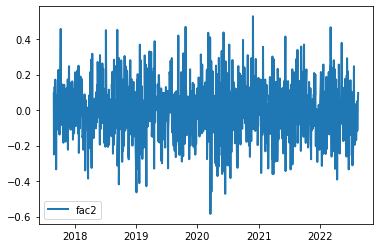

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1528016598.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group2']=train.groupby('date')['neu_fac2'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1528016598.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last_group2']=train.groupby('ticker')['group2'].shift(1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1528016598.py:15: SettingWithCopyWarning: 
A value is trying to be set on a

group
0.0    AxesSubplot(0.125,0.2;0.775x0.68)
1.0    AxesSubplot(0.125,0.2;0.775x0.68)
2.0    AxesSubplot(0.125,0.2;0.775x0.68)
3.0    AxesSubplot(0.125,0.2;0.775x0.68)
4.0    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumret, dtype: object

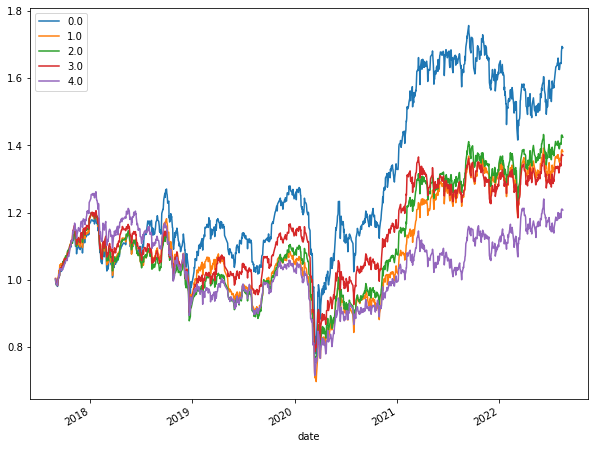

In [14]:
neu_fac2=train.groupby('date').apply(lambda x: neutralization(x['factor2'],x['mkt_cap'],x['bics_sector']))
index=neu_fac2.index.get_level_values(1)
neu_fac2.index=index
train['neu_fac2']=neu_fac2

ic2=train.groupby('date')[['ret','neu_fac2']].corr()
ic2=ic2.iloc[::2, 1]
ic2.index=ic2.index.get_level_values(0)
plt.plot(ic2.index,ic2, ls="-", lw=2, label="fac2")
plt.legend()
plt.show()

train['group2']=train.groupby('date')['neu_fac2'].apply(lambda x: pd.qcut(x,q=5,labels=False))
train['last_group2']=train.groupby('ticker')['group2'].shift(1)
train['ticker']=data.iloc[train.index,0]
daily_ret=train.groupby(['date','last_group2'])['pri_chg'].mean()
cumret2=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret2=cumret2.reset_index(drop=True)
cumret2['cumret']=cumret2.groupby('group')['grp_ret'].cumprod()
cumret2.set_index('date',inplace=True)
fig, ax = plt.subplots(figsize=(10, 8)) # 设置图片大小
cumret2.groupby('group')['cumret'].plot(legend=True,ax=ax)

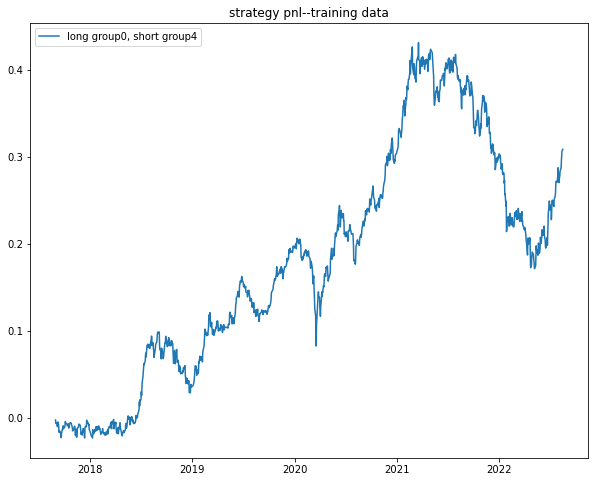

In [15]:
portfolio_ret=cumret2[cumret2['group']==0]['cumret']-cumret2[cumret2['group']==1]['cumret']
fig, ax = plt.subplots(figsize=(10, 8)) 
plt.plot(portfolio_ret.index,portfolio_ret,label='long group0, short group4')
plt.title('strategy pnl--training data')
plt.legend()

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1403013698.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['neu_fac3']=neu_fac3


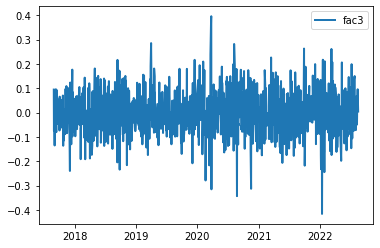

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1403013698.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group3']=train.groupby('date')['neu_fac3'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1403013698.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last_group3']=train.groupby('ticker')['group3'].shift(1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1403013698.py:15: SettingWithCopyWarning: 
A value is trying to be set on a

group
0.0    AxesSubplot(0.125,0.2;0.775x0.68)
1.0    AxesSubplot(0.125,0.2;0.775x0.68)
2.0    AxesSubplot(0.125,0.2;0.775x0.68)
3.0    AxesSubplot(0.125,0.2;0.775x0.68)
4.0    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumret, dtype: object

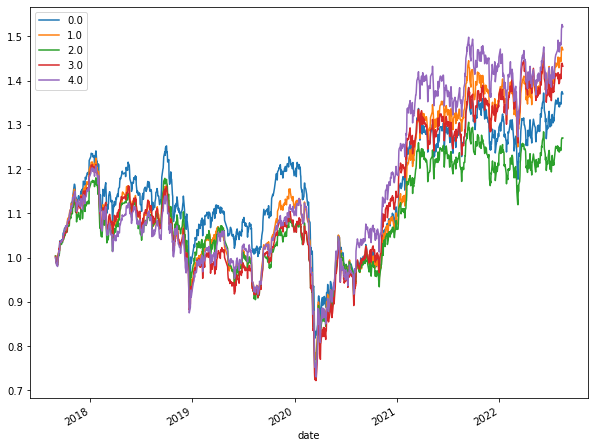

In [16]:
neu_fac3=train.groupby('date').apply(lambda x: neutralization(x['factor3'],x['mkt_cap'],x['bics_sector']))
index=neu_fac3.index.get_level_values(1)
neu_fac3.index=index
train['neu_fac3']=neu_fac3

ic3=train.groupby('date')[['ret','neu_fac3']].corr()
ic3=ic3.iloc[::2, 1]
ic3.index=ic3.index.get_level_values(0)
plt.plot(ic3.index,ic3, ls="-", lw=2, label="fac3")
plt.legend()
plt.show()

train['group3']=train.groupby('date')['neu_fac3'].apply(lambda x: pd.qcut(x,q=5,labels=False))
train['last_group3']=train.groupby('ticker')['group3'].shift(1)
train['ticker']=data.iloc[train.index,0]
daily_ret=train.groupby(['date','last_group3'])['pri_chg'].mean()
cumret3=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret3=cumret3.reset_index(drop=True)
cumret3['cumret']=cumret3.groupby('group')['grp_ret'].cumprod()
cumret3.set_index('date',inplace=True)
fig, ax = plt.subplots(figsize=(10, 8)) # 设置图片大小
cumret3.groupby('group')['cumret'].plot(legend=True,ax=ax)


C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1105580327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['neu_fac4']=neu_fac4


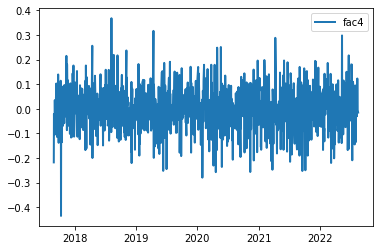

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1105580327.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group4']=train.groupby('date')['neu_fac4'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1105580327.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last_group4']=train.groupby('ticker')['group4'].shift(1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1105580327.py:15: SettingWithCopyWarning: 
A value is trying to be set on a

group
0.0    AxesSubplot(0.125,0.2;0.775x0.68)
1.0    AxesSubplot(0.125,0.2;0.775x0.68)
2.0    AxesSubplot(0.125,0.2;0.775x0.68)
3.0    AxesSubplot(0.125,0.2;0.775x0.68)
4.0    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumret, dtype: object

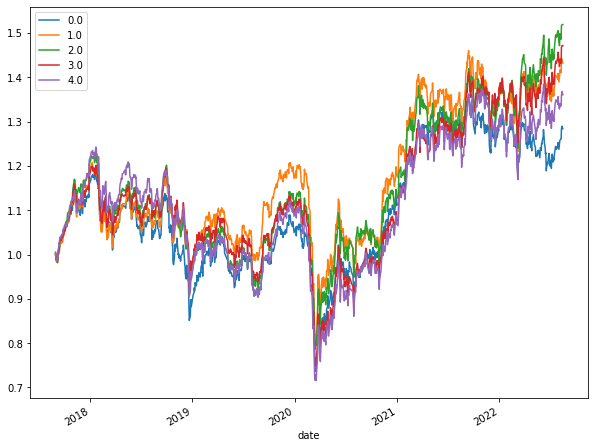

In [17]:
neu_fac4=train.groupby('date').apply(lambda x: neutralization(x['factor4'],x['mkt_cap'],x['bics_sector']))
index=neu_fac4.index.get_level_values(1)
neu_fac4.index=index
train['neu_fac4']=neu_fac4

ic4=train.groupby('date')[['ret','neu_fac4']].corr()
ic4=ic4.iloc[::2, 1]
ic4.index=ic4.index.get_level_values(0)
plt.plot(ic4.index,ic4, ls="-", lw=2, label="fac4")
plt.legend()
plt.show()

train['group4']=train.groupby('date')['neu_fac4'].apply(lambda x: pd.qcut(x,q=5,labels=False))
train['last_group4']=train.groupby('ticker')['group4'].shift(1)
train['ticker']=data.iloc[train.index,0]
daily_ret=train.groupby(['date','last_group4'])['pri_chg'].mean()
cumret4=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret4=cumret4.reset_index(drop=True)
cumret4['cumret']=cumret4.groupby('group')['grp_ret'].cumprod()
cumret4.set_index('date',inplace=True)
fig, ax = plt.subplots(figsize=(10, 8)) # 设置图片大小
cumret4.groupby('group')['cumret'].plot(legend=True,ax=ax)

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\2489593381.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['neu_fac5']=neu_fac5


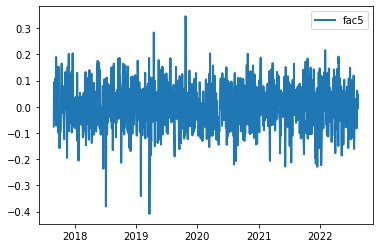

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\2489593381.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['group5']=train.groupby('date')['neu_fac5'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\2489593381.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['last_group5']=train.groupby('ticker')['group5'].shift(1)
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\2489593381.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

group
0.0    AxesSubplot(0.125,0.2;0.775x0.68)
1.0    AxesSubplot(0.125,0.2;0.775x0.68)
2.0    AxesSubplot(0.125,0.2;0.775x0.68)
3.0    AxesSubplot(0.125,0.2;0.775x0.68)
4.0    AxesSubplot(0.125,0.2;0.775x0.68)
Name: cumret, dtype: object

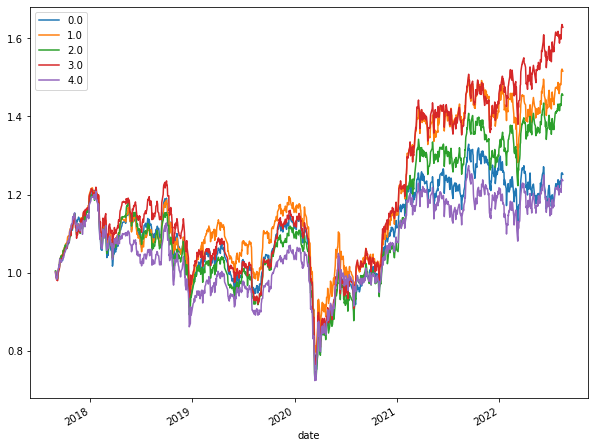

In [18]:
neu_fac5=train.groupby('date').apply(lambda x: neutralization(x['factor5'],x['mkt_cap'],x['bics_sector']))
index=neu_fac5.index.get_level_values(1)
neu_fac5.index=index
train['neu_fac5']=neu_fac5


ic5=train.groupby('date')[['ret','neu_fac5']].corr()
ic5=ic5.iloc[::2, 1]
ic5.index=ic5.index.get_level_values(0)
plt.plot(ic5.index,ic5, ls="-", lw=2, label="fac5")
plt.legend()
plt.show()

train['group5']=train.groupby('date')['neu_fac5'].apply(lambda x: pd.qcut(x,q=5,labels=False))
train['last_group5']=train.groupby('ticker')['group5'].shift(1)
train['ticker']=data.iloc[train.index,0]
daily_ret=train.groupby(['date','last_group5'])['pri_chg'].mean()
cumret5=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret5=cumret5.reset_index(drop=True)
cumret5['cumret']=cumret5.groupby('group')['grp_ret'].cumprod()
cumret5.set_index('date',inplace=True)
fig, ax = plt.subplots(figsize=(10, 8)) 
cumret5.groupby('group')['cumret'].plot(legend=True,ax=ax)

# Test

C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1230255961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['neu_fac2']=neu_fac2
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1230255961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['group2']=test.groupby('date')['neu_fac2'].apply(lambda x: pd.qcut(x,q=5,labels=False))
C:\Users\admin\AppData\Local\Temp\ipykernel_13200\1230255961.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

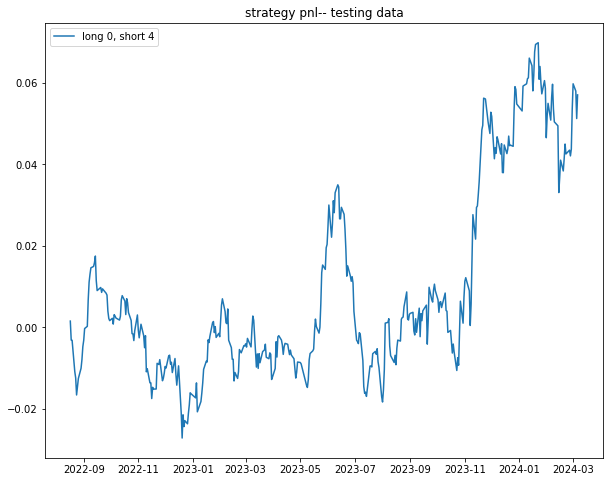

In [19]:
neu_fac2=test.groupby('date').apply(lambda x: neutralization(x['factor2'],x['mkt_cap'],x['bics_sector']))
index=neu_fac2.index.get_level_values(1)
neu_fac2.index=index
test['neu_fac2']=neu_fac2
test['group2']=test.groupby('date')['neu_fac2'].apply(lambda x: pd.qcut(x,q=5,labels=False))
test['ticker']=data.iloc[test.index,0]
test['last_group2']=test.groupby('ticker')['group2'].shift(1)
daily_ret=test.groupby(['date','last_group2'])['pri_chg'].mean()
cumret=pd.DataFrame({'date':daily_ret.index.get_level_values(0),'group':daily_ret.index.get_level_values(1),'grp_ret':daily_ret})
cumret=cumret.reset_index(drop=True)
cumret['cumret']=cumret.groupby('group')['grp_ret'].cumprod()
cumret.set_index('date',inplace=True)
portfolio_ret=cumret[cumret['group']==0]['cumret']-cumret[cumret['group']==1]['cumret']
fig, ax = plt.subplots(figsize=(10, 8)) 
plt.plot(portfolio_ret.index,portfolio_ret,label='long 0, short 4')
plt.title('strategy pnl-- testing data')
plt.legend()